# Exploring Chicago Neighborhoods to Identify Where to Open a Business

Importing necessary packages

In [2]:
import pandas as pd
import numpy as np

import json

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

Solving environment: ...working... done

# All requested packages already installed.



In [3]:
pd.set_option('display.max_row', 500)

Importing data

In [4]:
#Due to some of the extra characters included on the Wikipdia page where I got the community area data, 
#specifically parentheses in "The (Loop)", it was easier to put that data into a CSV file 
#and import the CSV file into Python rather than scrape the data from the Wikipedia page
df = pd.read_csv(r'C:\Users\lore\Desktop\Chicago communtiy area data.csv', header = 0)
df

,Number,Name,Population,Area,Density
0,1,Rogers Park,"55,062",1.84,"29,925.00"
1,2,West Ridge,"76,215",3.53,"21,590.65"
2,3,Uptown,"57,973",2.32,"24,988.36"
3,4,Lincoln Square,"41,715",2.56,"16,294.92"
4,5,North Center,"35,789",2.05,"17,458.05"
5,6,Lake View,"100,470",3.12,"32,201.92"
6,7,Lincoln Park,"67,710",3.16,"21,427.22"
7,8,Near North Side,"88,893",2.74,"32,442.70"
8,9,Edison Park,"11,605",1.13,"4,235.40"
9,10,Norwood Park,"37,089",4.37,"8,487.19"


In [5]:
df.shape

(77, 5)

Reading in location data - downloaded from here: https://github.com/jkgiesler/parse-chicago-neighborhoods/blob/master/community_to_gps.txt

In [6]:
df_loc = pd.read_csv(r'C:\Users\lore\Desktop\Chicago location data.csv', header = 0)
df_loc

,Community Area,Community Name,Latitude,Longitude
0,1,Rogers Park,42.003801,-87.657651
1,1,Rogers Park,42.002439,-87.657809
2,1,Rogers Park,41.998390,-87.657676
3,1,Rogers Park,42.009069,-87.661341
4,1,Rogers Park,42.005680,-87.660129
...,...,...,...,...
5159,77,Edgewater,41.997238,-87.660329
5160,77,Edgewater,41.997330,-87.660337
5161,77,Edgewater,41.987400,-87.654803
5162,77,Edgewater,41.987400,-87.654803


I'll be finding the median of the latitude and longitude for each community area to come up with centralized coordiantes to merge with the neighborhood data.

In [7]:
df_lat = pd.DataFrame(df_loc.groupby('Community Name')['Latitude'].median())
df_lat

,Latitude
Community Name,
Albany Park,41.968109
Archer Heights,41.803088
Armour Square,41.848920
Ashburn,41.747155
Auburn Gresham,41.750303
Austin,41.894324
Avalon Park,41.737811
Avondale,41.939170
Belmont Cragin,41.924038


In [8]:
df_long = pd.DataFrame(df_loc.groupby('Community Name')['Longitude'].median())
df_long

,Longitude
Community Name,
Albany Park,-87.715417
Archer Heights,-87.722579
Armour Square,-87.634046
Ashburn,-87.706452
Auburn Gresham,-87.657564
Austin,-87.763317
Avalon Park,-87.583892
Avondale,-87.714469
Belmont Cragin,-87.756711


Joining the coordinates to the rest of the data frame with an inner join

In [9]:
df_coord = pd.merge(left = df_lat, right = df_long, left_on = "Community Name", right_on = "Community Name")
df_coord

,Latitude,Longitude
Community Name,,
Albany Park,41.968109,-87.715417
Archer Heights,41.803088,-87.722579
Armour Square,41.848920,-87.634046
Ashburn,41.747155,-87.706452
Auburn Gresham,41.750303,-87.657564
Austin,41.894324,-87.763317
Avalon Park,41.737811,-87.583892
Avondale,41.939170,-87.714469
Belmont Cragin,41.924038,-87.756711


In [10]:
df_coord['Name'] = df_coord.index
df_coord

,Latitude,Longitude,Name
Community Name,,,
Albany Park,41.968109,-87.715417,Albany Park
Archer Heights,41.803088,-87.722579,Archer Heights
Armour Square,41.848920,-87.634046,Armour Square
Ashburn,41.747155,-87.706452,Ashburn
Auburn Gresham,41.750303,-87.657564,Auburn Gresham
Austin,41.894324,-87.763317,Austin
Avalon Park,41.737811,-87.583892,Avalon Park
Avondale,41.939170,-87.714469,Avondale
Belmont Cragin,41.924038,-87.756711,Belmont Cragin


In [11]:
df_comp = pd.merge(left = df, right = df_coord, left_on = "Name", right_on = "Name")
df_comp.head(77)

,Number,Name,Population,Area,Density,Latitude,Longitude
0,1,Rogers Park,"55,062",1.84,"29,925.00",42.008782,-87.668733
1,2,West Ridge,"76,215",3.53,"21,590.65",41.996179,-87.690408
2,3,Uptown,"57,973",2.32,"24,988.36",41.966252,-87.656868
3,4,Lincoln Square,"41,715",2.56,"16,294.92",41.968457,-87.685932
4,5,North Center,"35,789",2.05,"17,458.05",41.951533,-87.680136
5,6,Lake View,"100,470",3.12,"32,201.92",41.941426,-87.654559
6,7,Lincoln Park,"67,710",3.16,"21,427.22",41.921940,-87.651176
7,8,Near North Side,"88,893",2.74,"32,442.70",41.896508,-87.631284
8,9,Edison Park,"11,605",1.13,"4,235.40",42.004055,-87.815064
9,10,Norwood Park,"37,089",4.37,"8,487.19",41.991730,-87.798583


In [12]:
df_comp.shape

(77, 7)

In [13]:
df_comp['Population'] = df_comp['Population'].replace(',', '', regex = True)
df_comp['Density'] = df_comp['Density'].replace(',', '', regex = True)
df_comp.head()

,Number,Name,Population,Area,Density,Latitude,Longitude
0,1,Rogers Park,55062,1.84,29925.00,42.008782,-87.668733
1,2,West Ridge,76215,3.53,21590.65,41.996179,-87.690408
2,3,Uptown,57973,2.32,24988.36,41.966252,-87.656868
3,4,Lincoln Square,41715,2.56,16294.92,41.968457,-87.685932
4,5,North Center,35789,2.05,17458.05,41.951533,-87.680136


In [30]:
df_comp['Population'] = df_comp['Population'].apply(pd.to_numeric, errors = 'coerce')
df_comp['Area'] = df_comp['Area'].apply(pd.to_numeric, errors = 'coerce')
df_comp['Density'] = df_comp['Density'].apply(pd.to_numeric, errors = 'coerce')

Preparing some descriptive visuals

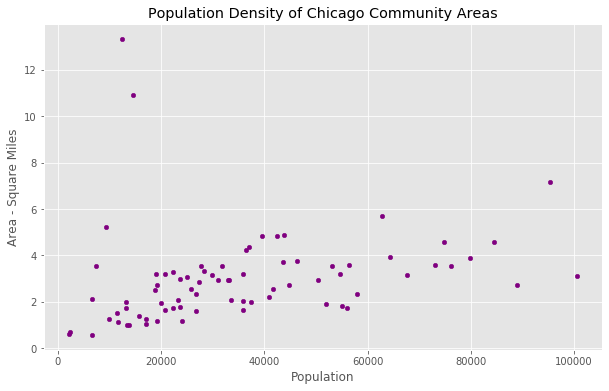

In [15]:
df_comp.plot(kind='scatter', x='Population', y='Area', figsize=(10, 6), color='purple')

plt.title('Population Density of Chicago Community Areas')
plt.xlabel('Population')
plt.ylabel('Area - Square Miles')

plt.show()

Identifying interesting plot points

In [16]:
df_comp[df_comp.Area > 6]

,Number,Name,Population,Area,Density,Latitude,Longitude
24,25,Austin,95260,7.15,13323.08,41.894324,-87.763317
50,51,South Deering,14614,10.90,1340.73,41.711486,-87.565629
75,76,O'Hare,12377,13.34,927.81,41.978169,-87.836965


In [17]:
df_comp[df_comp.Population > 80000]

,Number,Name,Population,Area,Density,Latitude,Longitude
5,6,Lake View,100470,3.12,32201.92,41.941426,-87.654559
7,8,Near North Side,88893,2.74,32442.70,41.896508,-87.631284
23,24,West Town,84502,4.58,18450.22,41.903125,-87.676432
24,25,Austin,95260,7.15,13323.08,41.894324,-87.763317


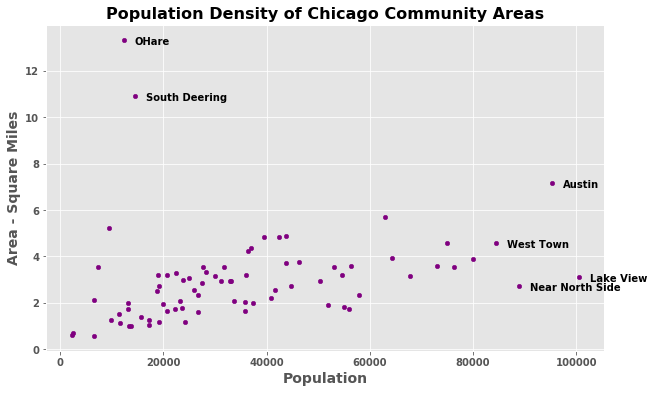

In [21]:
df_comp.plot(kind='scatter', x='Population', y='Area', figsize=(10, 6), color='purple')

plt.title('Population Density of Chicago Community Areas', fontsize = 16, fontweight ='bold')
plt.xlabel('Population', fontsize = 14, fontweight = 'bold')
plt.ylabel('Area - Square Miles', fontsize = 14, fontweight = 'bold')

plt.annotate('OHare', xy = (14500, 13.15), fontweight = 'bold')
plt.annotate('South Deering', xy = (16737, 10.71), fontweight = 'bold')
plt.annotate('Austin', xy = (97383, 6.96), fontweight = 'bold')
plt.annotate('Lake View', xy = (102593, 2.93), fontweight = 'bold')
plt.annotate('Near North Side', xy = (91016, 2.55), fontweight = 'bold')
plt.annotate('West Town', xy = (86625, 4.39), fontweight = 'bold')

plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')

plt.show()

In [20]:
plt.savefig('popdens.png')

<Figure size 432x288 with 0 Axes>

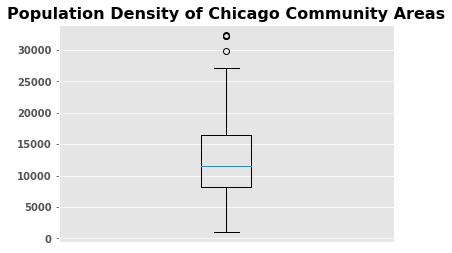

<Figure size 720x1440 with 0 Axes>

In [49]:
plt.boxplot(df_comp['Density'])
plt.title('Population Density of Chicago Community Areas', fontsize = 16, fontweight ='bold')
plt.xticks([])
plt.yticks(fontweight = 'bold')
plt.figure(figsize=(10,20))

plt.show()

In [50]:
plt.savefig('popdense bp.png')

<Figure size 432x288 with 0 Axes>

In [65]:
df_comp[df_comp.Density > 29000]

,Number,Name,Population,Area,Density,Latitude,Longitude
0,1,Rogers Park,55062,1.84,29925.00,42.008782,-87.668733
5,6,Lake View,100470,3.12,32201.92,41.941426,-87.654559
7,8,Near North Side,88893,2.74,32442.70,41.896508,-87.631284
76,77,Edgewater,55965,1.74,32163.79,41.982712,-87.660466


Merging in Location Data from foursquare

In [51]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordiantes of Chicago are {}, {}.'.format(latitude, longitude))

The geographical coordiantes of Chicago are 41.8755616, -87.6244212.


In [53]:
map_chicago = folium.Map(location = [latitude, longitude], zoom_start = 10)

for lat, lng, name, number in zip(df_comp['Latitude'], df_comp['Longitude'], df_comp['Name'], df_comp['Number']):
    label = '{}, {}'.format(name, number)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

In [54]:
CLIENT_ID = 'PHUNIQKA5WBPZ5G0JZKKISKUYI3FG3MVQOVARJYKM5JMGFWJ' 
CLIENT_SECRET = 'AC5544NIW4ESTTV3F1R5HDZH5MTPPH1D44NZV1VBCIEUPPIF'
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PHUNIQKA5WBPZ5G0JZKKISKUYI3FG3MVQOVARJYKM5JMGFWJ
CLIENT_SECRET:AC5544NIW4ESTTV3F1R5HDZH5MTPPH1D44NZV1VBCIEUPPIF


In [55]:
#testing venue acquisition on one community area
df_comp.loc[0, 'Name']

'Rogers Park'

In [56]:
ca_latitude = df_comp.loc[0, 'Latitude']
ca_longitude = df_comp.loc[0, 'Longitude']

ca_name = df_comp.loc[0, 'Name']

print('Latitude and longitude values of community area {} are {}, {}.'.format(ca_name,
                                                             ca_latitude,
                                                             ca_longitude))

Latitude and longitude values of community area Rogers Park are 42.008782000000004, -87.66873299999999.


In [57]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ca_latitude, 
    ca_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=PHUNIQKA5WBPZ5G0JZKKISKUYI3FG3MVQOVARJYKM5JMGFWJ&client_secret=AC5544NIW4ESTTV3F1R5HDZH5MTPPH1D44NZV1VBCIEUPPIF&v=20180604&ll=42.008782000000004,-87.66873299999999&radius=500&limit=100'

In [58]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed3e9ad83525f001bdacfaa'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Rogers Park',
  'headerFullLocation': 'Rogers Park, Chicago',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 32,
  'suggestedBounds': {'ne': {'lat': 42.013282004500006,
    'lng': -87.66268811837831},
   'sw': {'lat': 42.0042819955, 'lng': -87.67477788162167}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad3bfc1f964a52017e620e3',
       'name': 'Morse Fresh Market',
       'location': {'address': '1430 W Morse Ave',
        'crossStreet': 'at Greenview Ave',
        'lat': 42.008086562847986,
        'lng': -

In [59]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [60]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Morse Fresh Market,Grocery Store,42.008087,-87.667041
1,The Common Cup,Coffee Shop,42.007797,-87.667901
2,Glenwood Sunday Market,Farmers Market,42.008525,-87.666251
3,Rogers Park Social,Bar,42.007360,-87.666265
4,Smack Dab,Bakery,42.009291,-87.666201


In [61]:
#repliacting venue acquisition across all community areas in Chicago
def getNearbyVenues(names, latitudes, longitudes, radius = 500):

    venues_list = []
    for name, lat, long in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Name Latitude', 
                  'Name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues) 

In [62]:
chicago_venues = getNearbyVenues(names = df_comp['Name'],
                                latitudes = df_comp['Latitude'],
                                longitudes = df_comp['Longitude']
                                )

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater


In [63]:
print(chicago_venues.shape)
chicago_venues.head(15)

(1929, 7)


,Name,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.008782,-87.660466,Loyola Beach,42.008985,-87.659474,Beach
1,Rogers Park,42.008782,-87.660466,Giordano's,42.006576,-87.661511,Pizza Place
2,Rogers Park,42.008782,-87.660466,XO Marshmallow,42.008929,-87.661548,Café
3,Rogers Park,42.008782,-87.660466,Loyola Park,42.011390,-87.662364,Park
4,Rogers Park,42.008782,-87.660466,J.B. Alberto's Pizza,42.007941,-87.665066,Pizza Place
5,Rogers Park,42.008782,-87.660466,Pratt Boulevard Beach and Park,42.005719,-87.658533,Beach
6,Rogers Park,42.008782,-87.660466,Mayne Stage,42.007975,-87.665140,Concert Hall
7,Rogers Park,42.008782,-87.660466,SP Kebab,42.005823,-87.661049,Eastern European Restaurant
8,Rogers Park,42.008782,-87.660466,Twisted Tapas,42.005564,-87.660363,Tapas Restaurant
9,Rogers Park,42.008782,-87.660466,Asahi Roll,42.005543,-87.660996,Sushi Restaurant


In [64]:
chicago_venues.groupby('Name').count()

,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Name,,,,,,
Albany Park,53,53,53,53,53,53
Archer Heights,10,10,10,10,10,10
Armour Square,7,7,7,7,7,7
Ashburn,14,14,14,14,14,14
Auburn Gresham,11,11,11,11,11,11
Austin,56,56,56,56,56,56
Avalon Park,12,12,12,12,12,12
Avondale,39,39,39,39,39,39
Belmont Cragin,40,40,40,40,40,40


Analyzing the neighborhoods

In [66]:
print('There are {} unique categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 207 unique categories.


In [68]:
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix = "", prefix_sep = "")
chicago_onehot['Name'] = chicago_venues['Name']
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
chicago_onehot.head()

,Name,Accessories Store,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
chicago_onehot.shape

(1929, 208)

In [70]:
chicago_grouped = chicago_onehot.groupby('Name').mean().reset_index()
chicago_grouped

,Name,Accessories Store,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037736,0.00000,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000
1,Archer Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.100000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Armour Square,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Ashburn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Auburn Gresham,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Austin,0.017857,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.017857,...,0.000000,0.000000,0.000000,0.00000,0.017857,0.000000,0.035714,0.000000,0.000000,0.017857
6,Avalon Park,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Avondale,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641
8,Belmont Cragin,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.025000,0.000000,0.000000,0.02500,0.025000,0.000000,0.000000,0.000000,0.000000,0.025000
9,Beverly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [71]:
chicago_grouped.shape

(77, 208)

In [72]:
num_top_venues = 5
for code in chicago_grouped['Name']:
    print("----"+code+"----")
    temp = chicago_grouped[chicago_grouped['Name'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park----
                venue  freq
0         Pizza Place  0.09
1  Chinese Restaurant  0.08
2     Thai Restaurant  0.06
3               Diner  0.06
4         Coffee Shop  0.06


----Archer Heights----
                    venue  freq
0             Video Store   0.1
1                    Food   0.1
2          Cosmetics Shop   0.1
3             Pizza Place   0.1
4  Thrift / Vintage Store   0.1


----Armour Square----
          venue  freq
0   Music Venue  0.29
1  Soccer Field  0.29
2   Art Gallery  0.14
3    Donut Shop  0.14
4    Food Truck  0.14


----Ashburn----
               venue  freq
0  Currency Exchange  0.07
1          BBQ Joint  0.07
2       Liquor Store  0.07
3             Lounge  0.07
4   Greek Restaurant  0.07


----Auburn Gresham----
                  venue  freq
0              Pharmacy  0.18
1    Seafood Restaurant  0.09
2  Fast Food Restaurant  0.09
3             BBQ Joint  0.09
4                Lounge  0.09


----Austin----
              venue  freq
0       Piz

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [76]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pc_venues_sorted = pd.DataFrame(columns=columns)
pc_venues_sorted['Name'] = chicago_grouped['Name']

for ind in np.arange(chicago_grouped.shape[0]):
    pc_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

pc_venues_sorted.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Pizza Place,Chinese Restaurant,Diner,Thai Restaurant,Coffee Shop,Sushi Restaurant,Fast Food Restaurant,Bar,Music Venue,Vietnamese Restaurant
1,Archer Heights,Food,Thrift / Vintage Store,Pizza Place,Clothing Store,Discount Store,Fast Food Restaurant,Bank,Laundromat,Cosmetics Shop,Video Store
2,Armour Square,Soccer Field,Music Venue,Food Truck,Art Gallery,Donut Shop,Yoga Studio,Dog Run,Farmers Market,Farm,Ethiopian Restaurant
3,Ashburn,Cosmetics Shop,Greek Restaurant,Pharmacy,Dim Sum Restaurant,Discount Store,Fast Food Restaurant,Southern / Soul Food Restaurant,Basketball Court,Lounge,Bank
4,Auburn Gresham,Pharmacy,Cosmetics Shop,Park,Lounge,Seafood Restaurant,BBQ Joint,Fast Food Restaurant,Dim Sum Restaurant,Greek Restaurant,Discount Store


Clustering the neighborhoods

In [77]:
kclusters = 5
chicago_grouped_clustering = chicago_grouped.drop('Name', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)
kmeans.labels_[0:10]

array([2, 3, 2, 3, 3, 2, 2, 2, 2, 4])

In [78]:
pc_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_merged = df_comp
chicago_merged = chicago_merged.join(pc_venues_sorted.set_index('Name'), on='Name')
chicago_merged.head()

,Number,Name,Population,Area,Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Rogers Park,55062,1.84,29925.00,42.008782,-87.668733,2,Park,Beach,Bar,Pizza Place,Sushi Restaurant,Donut Shop,Bookstore,Café,Dive Bar,Coffee Shop
1,2,West Ridge,76215,3.53,21590.65,41.996179,-87.690408,2,Sandwich Place,Convenience Store,Coffee Shop,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Ethiopian Restaurant,Pharmacy,Mobile Phone Shop,Mexican Restaurant
2,3,Uptown,57973,2.32,24988.36,41.966252,-87.656868,2,Pizza Place,Coffee Shop,Chinese Restaurant,Diner,Thai Restaurant,Music Venue,Bar,Sushi Restaurant,Ethiopian Restaurant,Fast Food Restaurant
3,4,Lincoln Square,41715,2.56,16294.92,41.968457,-87.685932,2,Pizza Place,Chinese Restaurant,Coffee Shop,Vietnamese Restaurant,Thai Restaurant,Diner,Sushi Restaurant,Bar,Fast Food Restaurant,Music Venue
4,5,North Center,35789,2.05,17458.05,41.951533,-87.680136,2,General Entertainment,Ice Cream Shop,Sports Bar,New American Restaurant,Bar,Pizza Place,Yoga Studio,Rental Service,Baseball Stadium,Spa


In [79]:
chicago_merged.shape

(77, 18)

In [80]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Name'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Exploring clusters

In [82]:
chicago_merged['Cluster Labels'].value_counts()

2    52
3    11
0     7
1     6
4     1
Name: Cluster Labels, dtype: int64

Cluster 1

In [83]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Washington Park,41.794247,-87.619062,0,Southern / Soul Food Restaurant,Baseball Field,Park,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
40,Hyde Park,41.795496,-87.588089,0,Park,Baseball Field,Yoga Studio,Donut Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
49,Pullman,41.707010,-87.604845,0,Caribbean Restaurant,Men's Store,Park,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
50,South Deering,41.711486,-87.565629,0,Sandwich Place,Park,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
55,Garfield Ridge,41.792896,-87.773175,0,Southern / Soul Food Restaurant,Baseball Field,Park,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
61,West Elsdon,41.794820,-87.723526,0,Park,Southern / Soul Food Restaurant,Baseball Field,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
62,Gage Park,41.794108,-87.703477,0,Southern / Soul Food Restaurant,Baseball Field,Park,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant


Cluster 1 seems to be dominated by fitness - sports parks, yoga studios, and other outdoor spaces. There are also many restaurants. None of our population density outliers are in this cluster.  

Cluster 2

In [84]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Woodlawn,41.780605,-87.594340,1,Cosmetics Shop,Fast Food Restaurant,Train Station,Sandwich Place,Discount Store,Dive Bar,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
63,Clearing,41.777682,-87.774390,1,Fast Food Restaurant,Train Station,Sandwich Place,Discount Store,Yoga Studio,Dive Bar,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
64,West Lawn,41.776575,-87.722770,1,Fast Food Restaurant,Train Station,Park,Cosmetics Shop,Liquor Store,Discount Store,Wings Joint,Currency Exchange,Dance Studio,Cupcake Shop
65,Chicago Lawn,41.779086,-87.694115,1,Cosmetics Shop,Fast Food Restaurant,Train Station,Sandwich Place,Discount Store,Dive Bar,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
66,West Englewood,41.779255,-87.663956,1,Cosmetics Shop,Fast Food Restaurant,Train Station,Sandwich Place,Discount Store,Dive Bar,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
67,Englewood,41.779533,-87.642824,1,Cosmetics Shop,Fast Food Restaurant,Train Station,Sandwich Place,Discount Store,Dive Bar,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant


Cluster 2 is primarily defined by food and transit, but there is also some shopping. None of our outliers are in this cluster. 

Cluster 3

In [85]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rogers Park,42.008782,-87.668733,2,Park,Beach,Bar,Pizza Place,Sushi Restaurant,Donut Shop,Bookstore,Café,Dive Bar,Coffee Shop
1,West Ridge,41.996179,-87.690408,2,Sandwich Place,Convenience Store,Coffee Shop,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Ethiopian Restaurant,Pharmacy,Mobile Phone Shop,Mexican Restaurant
2,Uptown,41.966252,-87.656868,2,Pizza Place,Coffee Shop,Chinese Restaurant,Diner,Thai Restaurant,Music Venue,Bar,Sushi Restaurant,Ethiopian Restaurant,Fast Food Restaurant
3,Lincoln Square,41.968457,-87.685932,2,Pizza Place,Chinese Restaurant,Coffee Shop,Vietnamese Restaurant,Thai Restaurant,Diner,Sushi Restaurant,Bar,Fast Food Restaurant,Music Venue
4,North Center,41.951533,-87.680136,2,General Entertainment,Ice Cream Shop,Sports Bar,New American Restaurant,Bar,Pizza Place,Yoga Studio,Rental Service,Baseball Stadium,Spa
5,Lake View,41.941426,-87.654559,2,Performing Arts Venue,Sports Bar,Mexican Restaurant,Café,Cosmetics Shop,Yoga Studio,Boutique,Bowling Alley,Brewery,Sandwich Place
6,Lincoln Park,41.921940,-87.651176,2,Bar,Sandwich Place,Pizza Place,Mexican Restaurant,Coffee Shop,Gym / Fitness Center,Weight Loss Center,Spa,Breakfast Spot,Bridal Shop
7,Near North Side,41.896508,-87.631284,2,Pizza Place,Bar,Wine Shop,American Restaurant,Deli / Bodega,Scenic Lookout,Sandwich Place,Café,Pub,Pool
8,Edison Park,42.004055,-87.815064,2,Beach,Park,Pizza Place,Bar,Fast Food Restaurant,Sandwich Place,Mobile Phone Shop,Sushi Restaurant,Bookstore,Salon / Barbershop
9,Norwood Park,41.991730,-87.798583,2,Thai Restaurant,Mexican Restaurant,Mediterranean Restaurant,Grocery Store,Pharmacy,Convenience Store,Asian Restaurant,Pizza Place,Sandwich Place,Ethiopian Restaurant


Cluster 3 has a great variety of businesses, mosty domianted by restaurants and shopping. All four of our population density outliers are in this cluster.

Cluster 4

In [86]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Fuller Park,41.802111,-87.631719,3,Thrift / Vintage Store,Video Store,Cosmetics Shop,Food,Discount Store,Park,Fast Food Restaurant,Clothing Store,Deli / Bodega,Cupcake Shop
46,Burnside,41.725473,-87.600361,3,Food,Cosmetics Shop,Discount Store,Supermarket,Lounge,American Restaurant,Sandwich Place,Donut Shop,Fried Chicken Joint,Park
47,Calumet Heights,41.729546,-87.582300,3,Food,Fried Chicken Joint,Bar,Park,Train Station,Discount Store,Lounge,Yoga Studio,Dry Cleaner,Fast Food Restaurant
48,Roseland,41.692511,-87.621202,3,Food,Intersection,BBQ Joint,Sandwich Place,Track,Park,Discount Store,American Restaurant,Currency Exchange,Deli / Bodega
51,East Side,41.703524,-87.535365,3,Cosmetics Shop,American Restaurant,Salon / Barbershop,Park,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant
56,Archer Heights,41.803088,-87.722579,3,Food,Thrift / Vintage Store,Pizza Place,Clothing Store,Discount Store,Fast Food Restaurant,Bank,Laundromat,Cosmetics Shop,Video Store
69,Ashburn,41.747155,-87.706452,3,Cosmetics Shop,Greek Restaurant,Pharmacy,Dim Sum Restaurant,Discount Store,Fast Food Restaurant,Southern / Soul Food Restaurant,Basketball Court,Lounge,Bank
70,Auburn Gresham,41.750303,-87.657564,3,Pharmacy,Cosmetics Shop,Park,Lounge,Seafood Restaurant,BBQ Joint,Fast Food Restaurant,Dim Sum Restaurant,Greek Restaurant,Discount Store
72,Washington Heights,41.720964,-87.653160,3,Fast Food Restaurant,Sandwich Place,Plaza,Food,Supermarket,Fried Chicken Joint,Donut Shop,Cosmetics Shop,Discount Store,American Restaurant
73,Mount Greenwood,41.691674,-87.704809,3,Food,Intersection,BBQ Joint,Sandwich Place,Track,Park,Discount Store,American Restaurant,Currency Exchange,Deli / Bodega


Cluster 4 is defined by food and shopping.

Cluster 5

In [87]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 4, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,Beverly,41.716134,-87.67695,4,Department Store,Sandwich Place,Yoga Studio,Dog Run,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Ethiopian Restaurant,Empanada Restaurant


Cluster 4 only has one community area, whose top venues are mostly restaurants. 

Top venues for our population density outliers.

In [88]:
chicago_merged.loc[chicago_merged['Density'] > 29000, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rogers Park,42.008782,-87.668733,2,Park,Beach,Bar,Pizza Place,Sushi Restaurant,Donut Shop,Bookstore,Café,Dive Bar,Coffee Shop
5,Lake View,41.941426,-87.654559,2,Performing Arts Venue,Sports Bar,Mexican Restaurant,Café,Cosmetics Shop,Yoga Studio,Boutique,Bowling Alley,Brewery,Sandwich Place
7,Near North Side,41.896508,-87.631284,2,Pizza Place,Bar,Wine Shop,American Restaurant,Deli / Bodega,Scenic Lookout,Sandwich Place,Café,Pub,Pool
76,Edgewater,41.982712,-87.660466,2,Sandwich Place,Asian Restaurant,Bank,Sushi Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,Shipping Store,Bus Station,Chinese Restaurant,Pharmacy


The four community areas with high population densities have many restaurants, but not many coffee shops. Only one community area, Rogers Park, has enough coffee shops for it to fall into a common venue category. 

In [89]:
chicago_merged.loc[chicago_merged['Population'] > 80000, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Lake View,41.941426,-87.654559,2,Performing Arts Venue,Sports Bar,Mexican Restaurant,Café,Cosmetics Shop,Yoga Studio,Boutique,Bowling Alley,Brewery,Sandwich Place
7,Near North Side,41.896508,-87.631284,2,Pizza Place,Bar,Wine Shop,American Restaurant,Deli / Bodega,Scenic Lookout,Sandwich Place,Café,Pub,Pool
23,West Town,41.903125,-87.676432,2,Sushi Restaurant,Bar,Art Gallery,Auto Workshop,Auto Dealership,Coffee Shop,Dog Run,Indie Movie Theater,History Museum,Boat or Ferry
24,Austin,41.894324,-87.763317,2,Bar,Pizza Place,Sandwich Place,Sushi Restaurant,American Restaurant,Wine Shop,Burger Joint,Deli / Bodega,Coffee Shop,Yoga Studio


The four community areas with the highest populations (two of which overlap with the above list) are also primarily dominated by restaurants. West Town and Austin both have enough coffee shops for them to fall into top venues - 6th most common for West Town and 9th most common for Austin. 